In [2]:
import torch.nn as nn
import torch.utils
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import time
from Common import NeuralNet, MultiVariatePoly
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,1]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=2,
                                                output_dimension=2,
                                                n_hidden_layers=4,
                                                neurons=20,
                                                regularization_param=0.,
                                                regularization_exp=2.,
                                                retrain_seed=45,
                                                )

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sbTf, self.training_set_sbTs, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation Ts0(x)=Tf0(x)=1
    def initial_condition(self, x):
        return torch.ones((x.shape[0], 1))

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    # same for both functions
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        input_tb = self.soboleng.draw(self.n_tb)
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb #columns vectors

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    # different for Tf
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0_Tf = (3/(1 + torch.exp(-200 * (input_sb_0[:,0]-0.25))) + 1).reshape(-1,1)
        output_sb_L_Tf = torch.zeros((input_sb.shape[0], 1))
        output_sb_0_Ts = torch.zeros((input_sb.shape[0], 1))
        output_sb_L_Ts = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0_Tf, output_sb_L_Tf], 0), torch.cat([output_sb_0_Ts, output_sb_L_Ts], 0) #column vectors

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_sb, output_sbTf, output_sbTs = self.add_spatial_boundary_points()   # S_s
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sbTf = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sbTf), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_sbTs = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sbTs), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sbTf, training_set_sbTs, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tbTf = self.approximate_solution(input_tb)[:,0].reshape(-1,1)
        u_pred_tbTs = self.approximate_solution(input_tb)[:,1].reshape(-1,1)
        return u_pred_tbTf, u_pred_tbTs

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sbTf = self.approximate_solution(input_sb)[:,0].reshape(-1,1)
        u_pred_sbTs = self.approximate_solution(input_sb)[:,1].reshape(-1,1)
        return u_pred_sbTf, u_pred_sbTs

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)[:,0]
        v = self.approximate_solution(input_int)[:,1]

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]
        grad_v = torch.autograd.grad(v.sum(), input_int, create_graph=True)[0]
        grad_v_t = grad_v[:, 0]
        grad_v_x = grad_v[:, 1]
        grad_v_xx = torch.autograd.grad(grad_v_x.sum(), input_int, create_graph=True)[0][:, 1]

        residualint1 = grad_u_t + grad_u_x - 0.05 * grad_u_xx + 5 * (u - v)
        residualint2 = grad_v_t - 0.08 * grad_v_xx - 6 * (u - v)
        return residualint1.reshape(-1, 1), residualint2.reshape(-1, 1)

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sbTf, u_train_sbTs, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        inp_train_sb.requires_grad = True
        u_pred_sbTf, u_pred_sbTs = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tbTf, u_pred_tbTs = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sbTf.shape[1] == u_train_sbTf.shape[1])
        assert (u_pred_tbTf.shape[1] == u_train_tb.shape[1])
        assert (u_pred_sbTs.shape[1] == u_train_sbTs.shape[1])
        assert (u_pred_tbTs.shape[1] == u_train_tb.shape[1])

        leng = int(u_train_sbTf.shape[0]/2)


        #print("inp_train_sb", inp_train_sb)
        #print("inp_int", inp_train_int)
        #print("u_train_sbTf", u_train_sbTf)
        #print("inp_train_tb", inp_train_tb)

        r_int1,r_int2 = self.compute_pde_residual(inp_train_int)
        #print("r_int:", r_int1.shape, r_int2.shape)
        r_int = torch.cat([r_int1, r_int2], 0)
        #print("r_int:", r_int.shape)
        r_sb0Tf = (u_train_sbTf[:leng,0] - u_pred_sbTf[:leng,0]).reshape(-1,1)
        grad_pred_Tf = torch.autograd.grad(u_pred_sbTf.sum(), inp_train_sb, create_graph=True)[0]
        r_sbLTf = (u_train_sbTf[leng:,0] - grad_pred_Tf[leng:,1]).reshape(-1,1)
        #print("r_sbTf:", r_sb0Tf.shape, r_sbLTf.shape)
        r_tbTf = u_train_tb - u_pred_tbTf
        #print("r_tbTf:", r_tbTf.shape)
        grad_pred_Ts = torch.autograd.grad(u_pred_sbTs.sum(), inp_train_sb, create_graph=True)[0]
        r_sb0Ts = (u_train_sbTs[:leng,0] - grad_pred_Ts[:leng,1]).reshape(-1,1)
        r_sbLTs = (u_train_sbTs[leng:,0] - grad_pred_Ts[leng:,1]).reshape(-1,1)
        #print("r_sbTs:", r_sb0Ts.shape, r_sbLTs.shape)
        r_tbTs = u_train_tb - u_pred_tbTs
        #print("r_tbTs:", r_tbTs.shape)
        r_tb = torch.cat([r_tbTf, r_tbTs], 0)
        r_sb = torch.cat([r_sb0Tf, r_sbLTf, r_sb0Ts, r_sbLTs], 0)
        #print("r_tb", r_tb.shape,"r_sb", r_sb.shape )

        #loss_sb0Tf = torch.mean(abs(r_sb0Tf) ** 2)
        #loss_sbLTf = torch.mean(abs(r_sbLTf) ** 2)
        #loss_sb0Ts = torch.mean(abs(r_sb0Ts) ** 2)
        #loss_sbLTs = torch.mean(abs(r_sbLTs) ** 2)
        #loss_tbTf = torch.mean(abs(r_tbTf) ** 2)
        #loss_tbTs = torch.mean(abs(r_tbTs) ** 2)
        loss_int1 = torch.mean(abs(r_int1) ** 2)
        loss_int2 = torch.mean(abs(r_int2) ** 2)
        #loss_int = torch.mean(abs(r_int)**2)
        loss_tb = torch.mean(abs(r_tb)**2)
        loss_sb = torch.mean(abs(r_sb)**2)

        #loss_u = loss_sb0Tf + loss_sbLTf + loss_sb0Ts + loss_sbLTs + loss_tbTf + loss_tbTs
        loss_u = loss_tb + loss_sb

        loss = torch.log10(self.lambda_u * loss_u + loss_int1 + loss_int2)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int1 + loss_int2).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sbTf), (inp_train_sb, u_train_sbTs), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sbTf, self.training_set_sbTs, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sbTf, u_train_sbTs, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        outputTf = self.approximate_solution(inputs)[:,0].reshape(-1, )
        outputTs = self.approximate_solution(inputs)[:,1].reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=outputTf.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution Tf")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=outputTs.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[1].set_title("Approximate Solution Ts")

        plt.show()

    def plottingcheck(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)
        inputs0 = torch.clone(inputs)
        inputs0[:,1] = torch.full(inputs0[:,1].shape, 0)
        inputs05 = torch.clone(inputs)
        inputs05[:,1] = torch.full(inputs05[:,1].shape, 0.5)
        inputs1 = torch.clone(inputs)
        inputs1[:,1] = torch.full(inputs1[:,1].shape, 1)

        outputTf0 = self.approximate_solution(inputs0)[:,0].reshape(-1, )
        outputTs0 = self.approximate_solution(inputs0)[:,1].reshape(-1, )
        outputTf05 = self.approximate_solution(inputs05)[:,0].reshape(-1, )
        outputTs05 = self.approximate_solution(inputs05)[:,1].reshape(-1, )
        outputTf1 = self.approximate_solution(inputs1)[:,0].reshape(-1, )
        outputTs1 = self.approximate_solution(inputs1)[:,1].reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        axs[0].scatter(inputs0[:, 0].detach(), outputTf0.detach(), cmap="jet")
        axs[0].scatter(inputs05[:, 0].detach(), outputTf05.detach(), cmap="jet")
        axs[0].scatter(inputs1[:, 0].detach(), outputTf1.detach(), cmap="jet")
        axs[0].scatter(inputs0[:, 0].detach(), outputTs0.detach(), cmap="jet")
        axs[0].scatter(inputs05[:, 0].detach(), outputTs05.detach(), cmap="jet")
        axs[0].scatter(inputs1[:, 0].detach(), outputTs1.detach(), cmap="jet")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("T")
        axs[0].grid(True, which="both", ls=":")


In [3]:
n_int = 4096
n_sb = 512
n_tb = 512

pinn = Pinns(n_int, n_sb, n_tb)

In [4]:
n_epochs = 5
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

################################  0  ################################
Total loss:  2.2166 | PDE Loss:  1.0052 | Function Loss:  1.8025
Total loss:  2.1436 | PDE Loss:  0.9792 | Function Loss:  1.6422
Total loss:  2.0193 | PDE Loss:  0.8629 | Function Loss:  1.5
Total loss:  1.9902 | PDE Loss:  0.8648 | Function Loss:  1.3895
Total loss:  1.9203 | PDE Loss:  0.8391 | Function Loss:  1.1523
Total loss:  1.8351 | PDE Loss:  0.7704 | Function Loss:  0.9758
Total loss:  1.7441 | PDE Loss:  0.6698 | Function Loss:  0.9406
Total loss:  1.6067 | PDE Loss:  0.4949 | Function Loss:  0.9624
Total loss:  1.5012 | PDE Loss:  0.342 | Function Loss:  0.9882
Total loss:  1.43 | PDE Loss:  0.288 | Function Loss:  0.8755
Total loss:  1.274 | PDE Loss:  0.2283 | Function Loss:  0.2738
Total loss:  1.2159 | PDE Loss:  0.1759 | Function Loss:  0.1603
Total loss:  1.0917 | PDE Loss:  0.0423 | Function Loss:  0.1239
Total loss:  1.0304 | PDE Loss:  -0.021 | Function Loss:  0.0777
Total loss:  0.9999 | PDE Lo

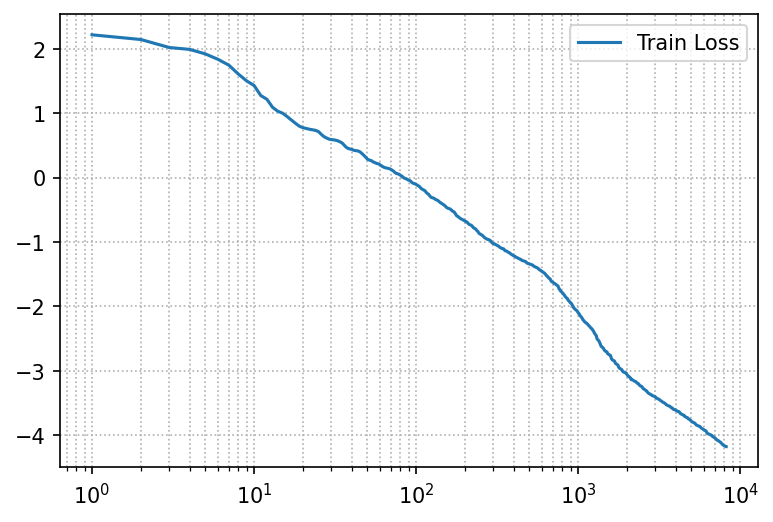

In [5]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

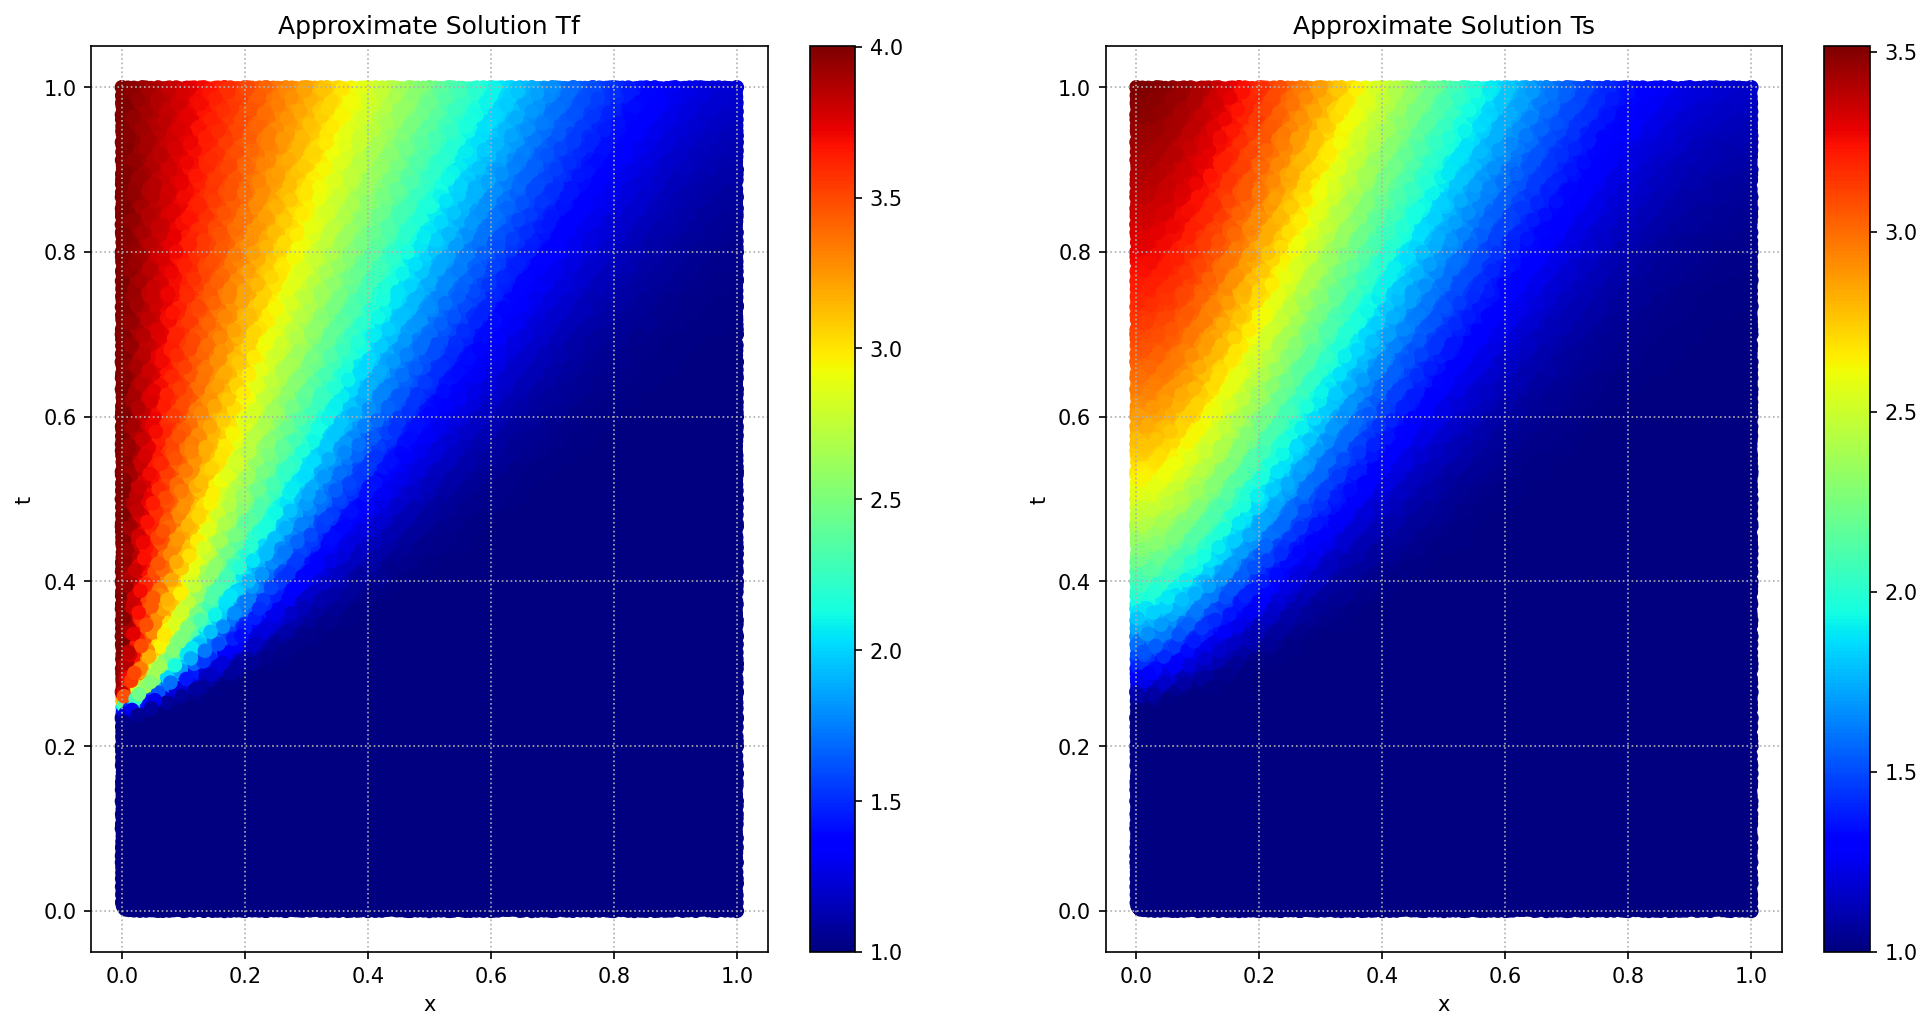

In [6]:
pinn.plotting()

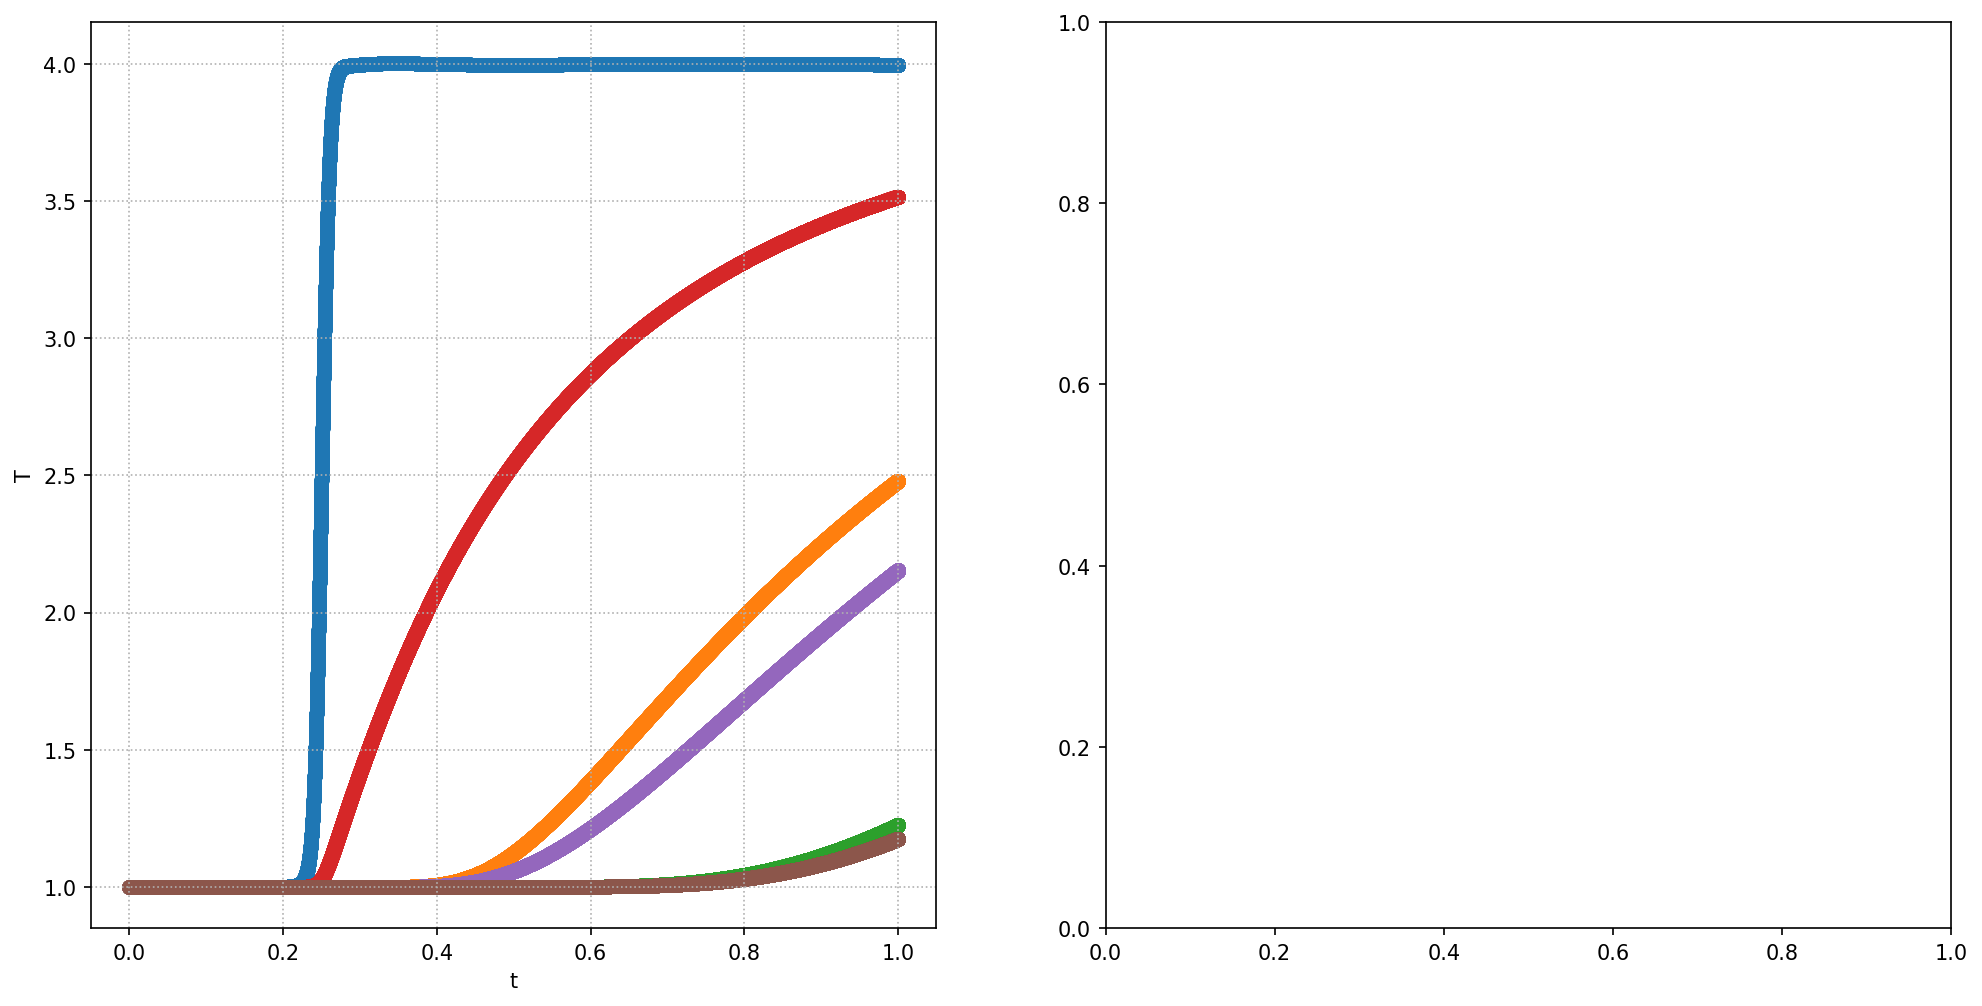

In [7]:
pinn.plottingcheck()

In [8]:
test=np.loadtxt("TestingData.txt", delimiter=",", skiprows=1)
t=test[:,0]
x=test[:,1]
print(max(t), max(x))
input=torch.from_numpy(test).type(torch.float32)

0.9599781249999999 1.0


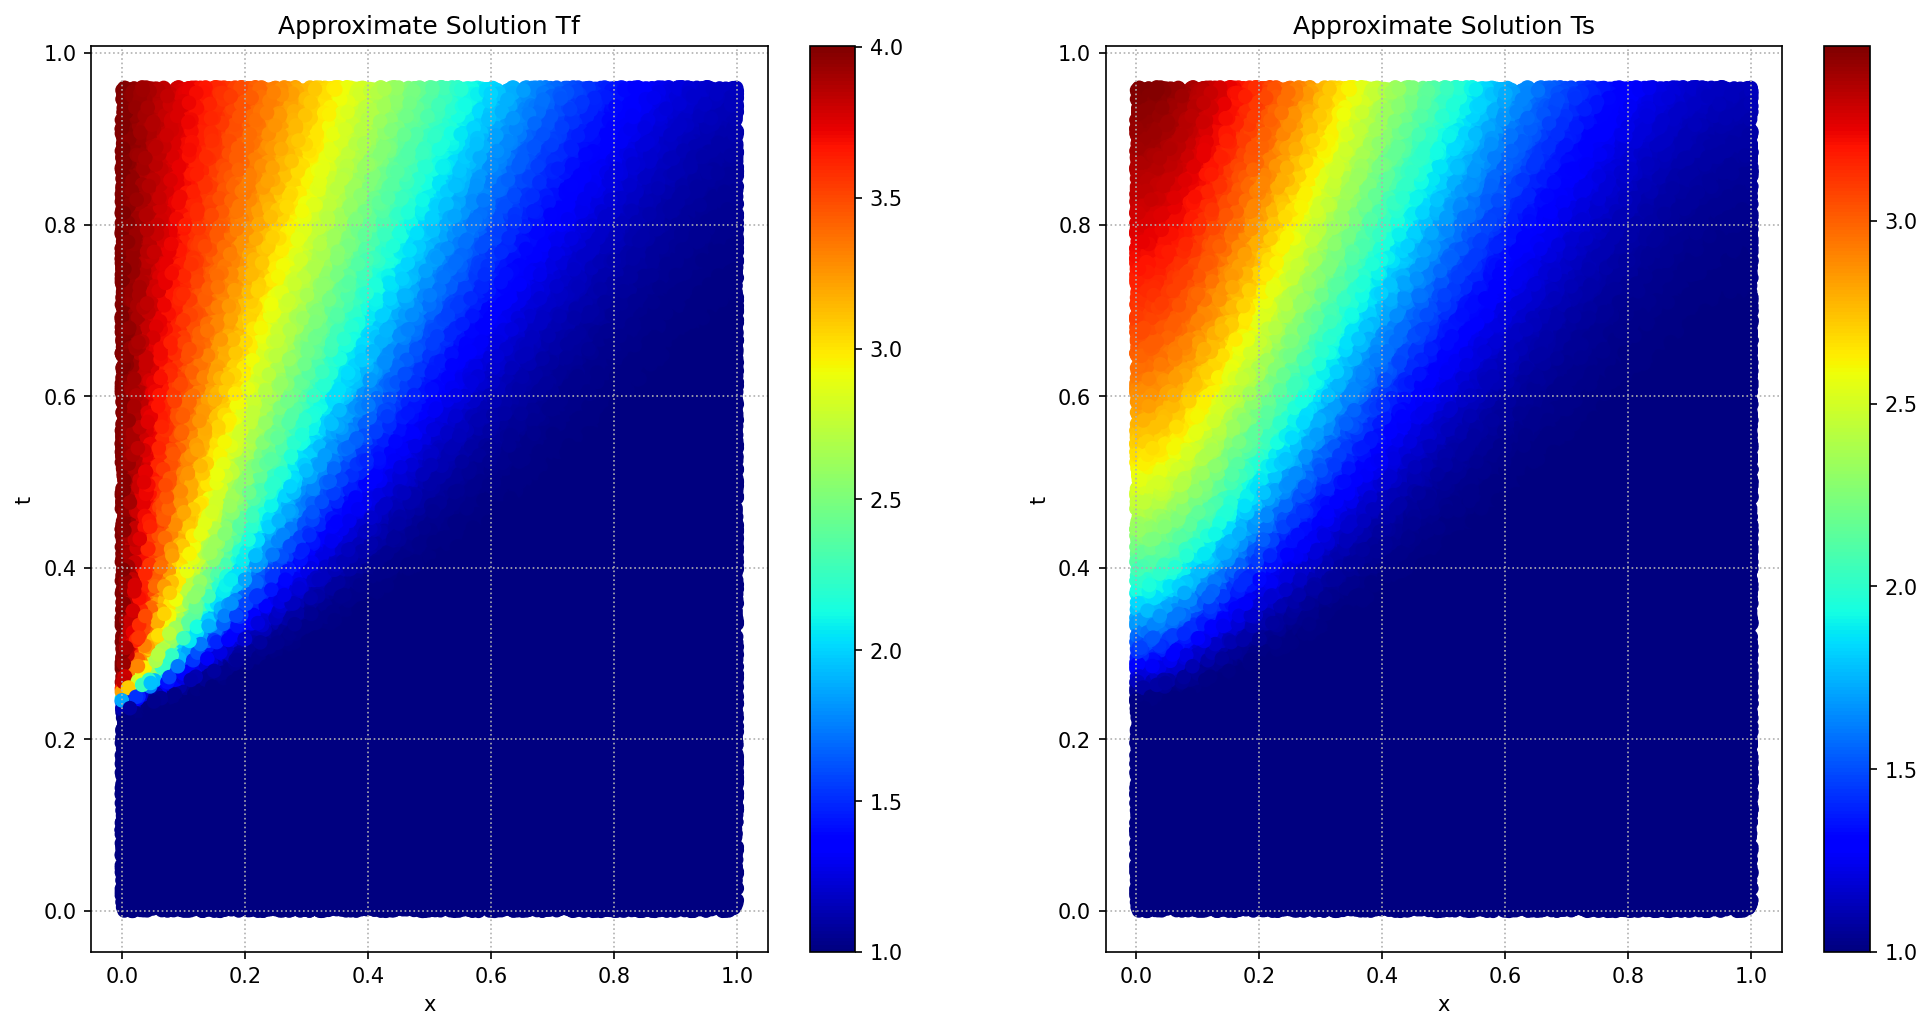

In [20]:
outputTf = pinn.approximate_solution(input)[:,0].reshape(-1, )
outputTs = pinn.approximate_solution(input)[:,1].reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(input[:, 1].detach(), input[:, 0].detach(), c=outputTf.detach(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution Tf")
im2 = axs[1].scatter(input[:, 1].detach(), input[:, 0].detach(), c=outputTs.detach(), cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[1].set_title("Approximate Solution Ts")

plt.show()